In [7]:
%matplotlib inline
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import brewer2mpl
import math
import pandas as pd
bmap = brewer2mpl.get_map('Set2', 'qualitative', 8)
colors = bmap.mpl_colors

In [8]:
LOGDIR = '../../results1000/'
PARAMS = [
'sarst_future_comp_1_inf_linear_True_True_1000_1',
# 'sarst_future_comp_1_inf_linear_True_True_1000_0.5',
'sarst_future_comp_1_inf_linear_True_True_1000_0.3',
          'sarst_future_comp_1_inf_linear_True_True_1000_2',
#           'sarst_future_comp_1_inf_linear_True_True_1000_3'
]

In [9]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    param_names = ['memory', 'strategy', 'sampler', 'alpha', 'delta', 'activation', 'invert_grads', 'target_clip']
    res_steps = glob.glob(LOGDIR + PARAM + '/*/' + 'log_steps/progress.json')
    for num_run, run in enumerate(res_steps):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_steps = pd.concat(frames, ignore_index=True)
expe_res_steps

,Test reward on initial goal,Test reward on random goal,critic_loss,d_q_values,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,q_values,reference_action_grads,training_step,params,num_run
0,NaN,NaN,97.299805,"[0.017474664375185002, 0.017372911795973, 0.01...",0.299604,0.027213,-0.008179,0.004818,"[0.017474664375185002, 0.017372911795973, 0.01...",0.007704,200,sarst_future_comp_1_inf_linear_True_True_1000_1,0
1,NaN,NaN,35.676125,"[0.017474664375185002, 0.017372911795973, 0.01...",0.553617,0.769161,0.011336,0.019042,"[0.017474664375185002, 0.017372911795973, 0.01...",0.183667,400,sarst_future_comp_1_inf_linear_True_True_1000_1,0
2,NaN,NaN,20.163557,"[0.017474664375185002, 0.017372911795973, 0.01...",0.360890,0.977426,0.032465,0.076534,"[0.017474664375185002, 0.017372911795973, 0.01...",0.252963,600,sarst_future_comp_1_inf_linear_True_True_1000_1,0
3,NaN,NaN,19.324163,"[0.017474664375185002, 0.017372911795973, 0.01...",0.209740,0.899050,-0.042657,0.158922,"[0.017474664375185002, 0.017372911795973, 0.01...",0.135524,800,sarst_future_comp_1_inf_linear_True_True_1000_1,0
4,-20.147221,-14.539778,13.523428,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.024829,0.835640,-0.258528,0.247352,"[0.017474664375185002, 0.017372911795973, 0.01...",0.082830,1000,sarst_future_comp_1_inf_linear_True_True_1000_1,0
5,-20.147221,-14.539778,11.104693,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.332904,-0.337404,-0.509749,0.301092,"[0.017474664375185002, 0.017372911795973, 0.01...",0.058994,1200,sarst_future_comp_1_inf_linear_True_True_1000_1,0
6,-20.147221,-14.539778,7.894825,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.490373,0.472873,-0.672434,0.313219,"[0.017474664375185002, 0.017372911795973, 0.01...",0.085414,1400,sarst_future_comp_1_inf_linear_True_True_1000_1,0
7,-20.147221,-14.539778,6.883845,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.519031,0.652916,-0.672563,0.335451,"[0.017474664375185002, 0.017372911795973, 0.01...",0.101775,1600,sarst_future_comp_1_inf_linear_True_True_1000_1,0
8,-20.147221,-14.539778,6.724186,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.542123,0.546224,-0.659549,0.354743,"[0.017474664375185002, 0.017372911795973, 0.01...",0.110001,1800,sarst_future_comp_1_inf_linear_True_True_1000_1,0
9,-15.973902,32.174069,5.071509,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.564497,0.082890,-0.672257,0.351100,"[0.017474664375185002, 0.017372911795973, 0.01...",0.082937,2000,sarst_future_comp_1_inf_linear_True_True_1000_1,0


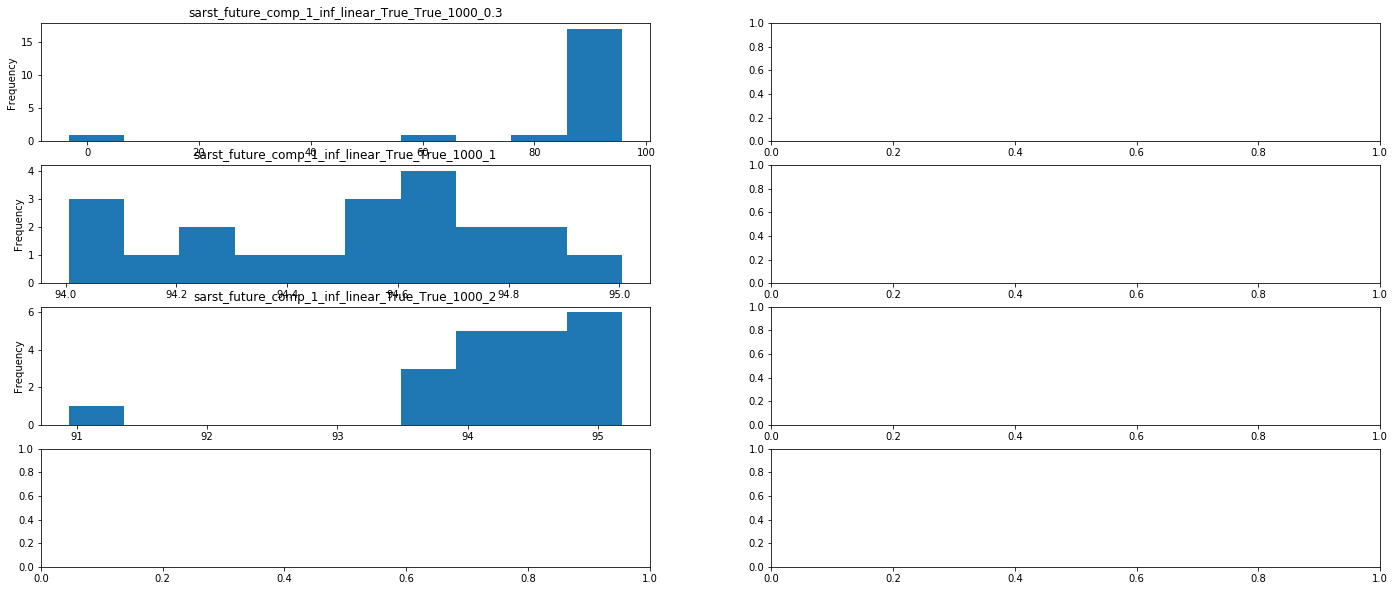

In [10]:
res_final = expe_res_steps[expe_res_steps['training_step']==200000]
fig, axes = plt.subplots(4,2, figsize=(24,10))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on initial goal']):
    g.plot(kind='hist', title=name, ax=axes[i%4, i//4])

In [11]:
dico = {}
for name, g in expe_res_steps[expe_res_steps['training_step']==200000].groupby('params'):
    dico[name] = list(g[g['Test reward on initial goal']>20]['num_run'].values)
mask = expe_res_steps.apply(lambda g: g['num_run'] in dico[g['params']], axis=1)
filtered = expe_res_steps[mask]

In [12]:
def quant_inf(x) : return x.quantile(0.2)
def quant_sup(x) : return x.quantile(0.8)
op_dict = {'Test reward on initial goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on initial goal','training_step','params']
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

In [13]:
stats_eval_init_smooth = stats_eval_init[['params','Test reward on initial goal']].groupby('params').apply(lambda x: x.ewm(30).mean())
stats_eval_init_smooth['training_step'] = stats_eval_init['training_step']

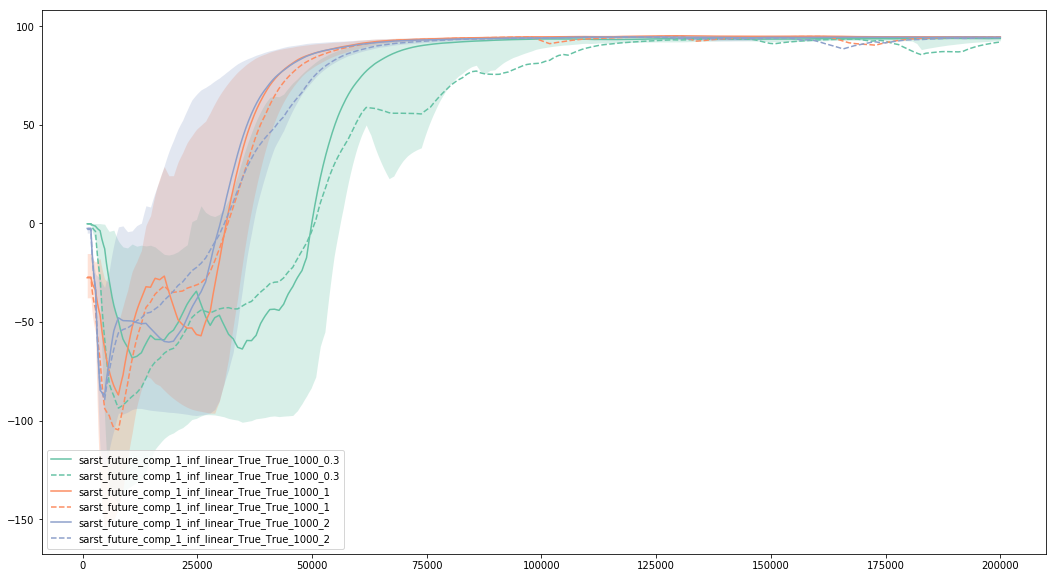

In [14]:
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    if name in PARAMS:
        ax.plot(g['training_step'], g['Test reward on initial goal']['median'], label=name, color=colors[i])
        ax.plot(g['training_step'], g['Test reward on initial goal']['mean'], label=name, color=colors[i], linestyle='dashed')
        ax.fill_between(g['training_step'], 
                        g['Test reward on initial goal']['quant_inf'], 
                        g['Test reward on initial goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()

In [15]:
means_steps = expe_res_steps.groupby(['training_step','params']).mean()
means_steps.reset_index(level=['training_step', 'params'], inplace=True)
means_steps

,training_step,params,Test reward on initial goal,Test reward on random goal,critic_loss,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,num_run,reference_action_grads
0,200,hsarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,160.045518,2.026046,0.040123,0.004600,0.006068,9.5,0.013705
1,200,hsarst_future_rnd_1_inf_tanh_True_True_200,NaN,NaN,294.593283,6.701143,-0.106886,0.020093,-0.008882,9.5,0.002265
2,200,sarst_final_comp_1_inf_tanh_True_True_200,NaN,NaN,7.794630,0.013958,0.004855,0.000029,-0.003531,9.5,-0.000171
3,200,sarst_final_intervalC_1_inf_tanh_True_True_200,NaN,NaN,2.927530,0.010848,0.004666,0.005298,-0.001938,9.5,-0.000150
4,200,sarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,5.607081,0.022078,-0.009665,-0.001834,0.000897,19.5,-0.000471
5,400,hsarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,735.522202,22.399515,0.145414,0.121125,0.009188,9.5,0.212813
6,400,hsarst_future_rnd_1_inf_tanh_True_True_200,NaN,NaN,1072.798895,44.317705,0.124283,0.230423,-0.006343,9.5,0.443676
7,400,sarst_final_comp_1_inf_tanh_True_True_200,NaN,NaN,10.032394,0.167451,0.031822,0.008825,-0.003284,9.5,0.008468
8,400,sarst_final_intervalC_1_inf_tanh_True_True_200,NaN,NaN,2.448528,0.029927,0.076892,0.004489,-0.000371,9.5,0.003054
9,400,sarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,8.071793,0.119926,0.015030,0.003052,0.000257,19.5,-0.003367


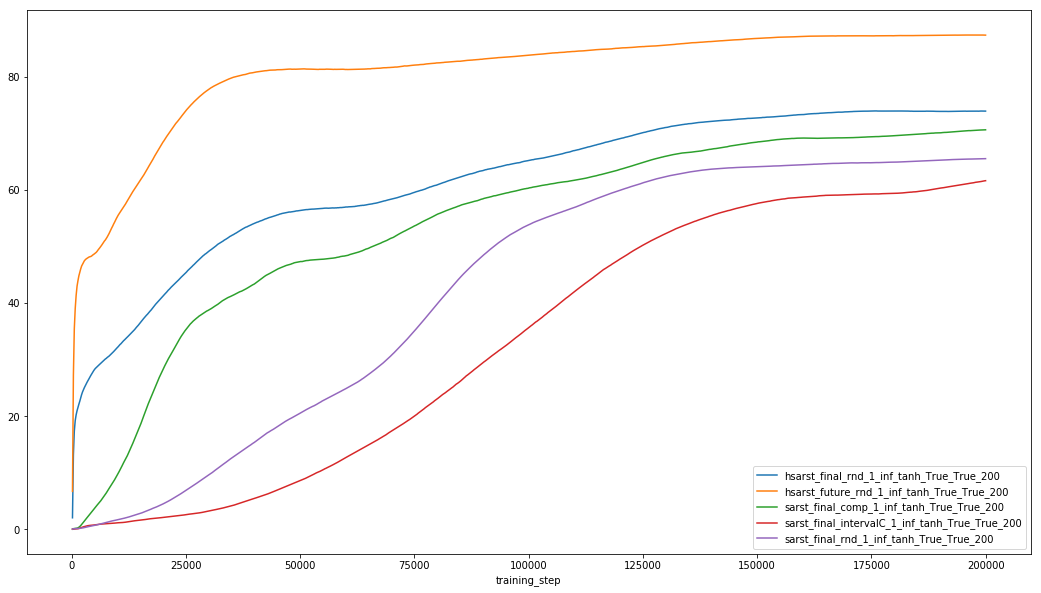

In [16]:
means_steps['mean_Q_values'] = means_steps.groupby('params')['mean_Q_values'].apply(lambda x: x.ewm(5).mean())
fig, ax = plt.subplots(figsize=(18,10))
for name, g in means_steps.groupby(['params'])[['training_step','mean_Q_values']]:
    g.plot(x='training_step',y='mean_Q_values', label=name, ax=ax)

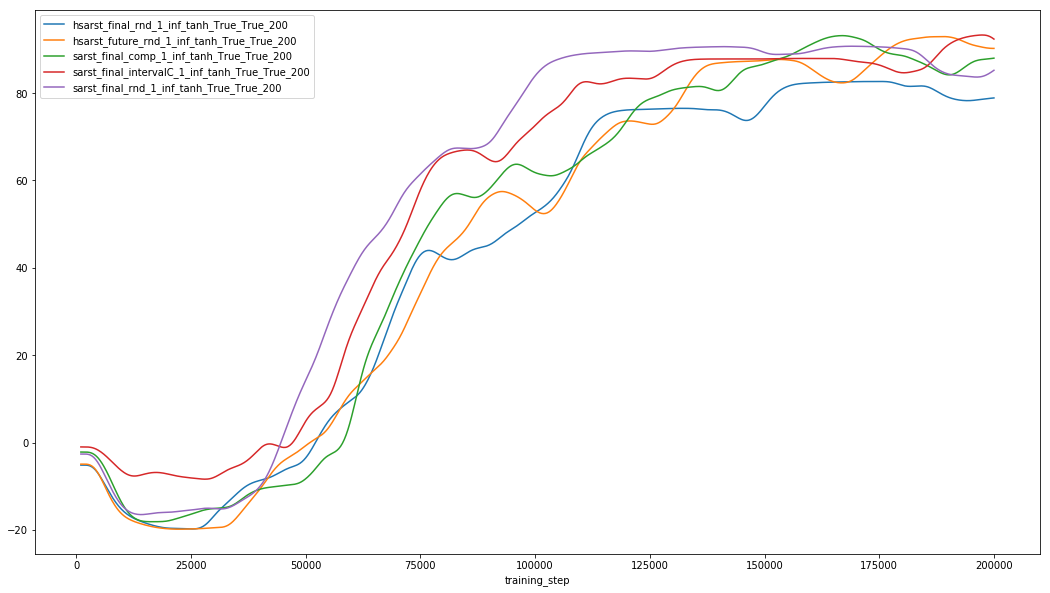

In [35]:
means_steps['Test reward on initial goal'] = means_steps.groupby('params')['Test reward on initial goal'].apply(lambda x: x.ewm(5).mean())
fig, ax = plt.subplots(figsize=(18,10))
for name, g in means_steps.groupby(['params'])[['training_step','Test reward on initial goal']]:
    g.plot(x='training_step',y='Test reward on initial goal', label=name, ax=ax)
#     x = g['training_step'].values
#     y = g['Test reward on initial goal'].values
#     ax.fill_between(x, y-10, y+10, alpha=0.25, linewidth=0)
#     break

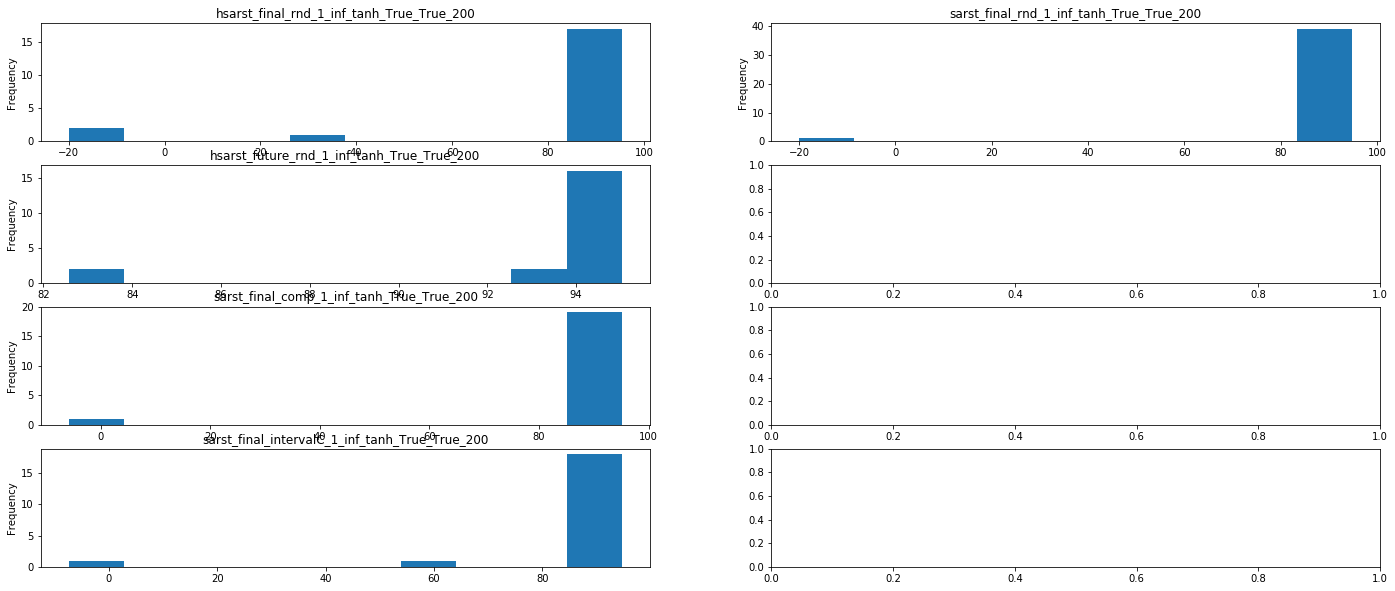

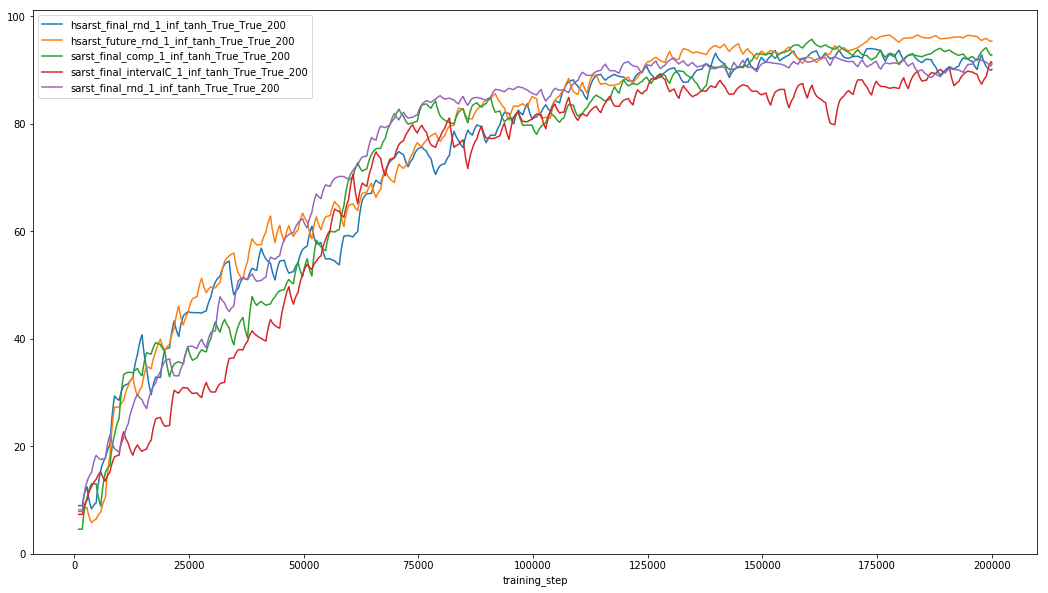

In [19]:
means_steps['Test reward on random goal'] = means_steps.groupby('params')['Test reward on random goal'].apply(lambda x: x.ewm(5).mean())
fig, ax = plt.subplots(figsize=(18,10))
for name, g in means_steps.groupby(['params'])[['training_step','Test reward on random goal']]:
    g.plot(x='training_step',y='Test reward on random goal', label=name, ax=ax)

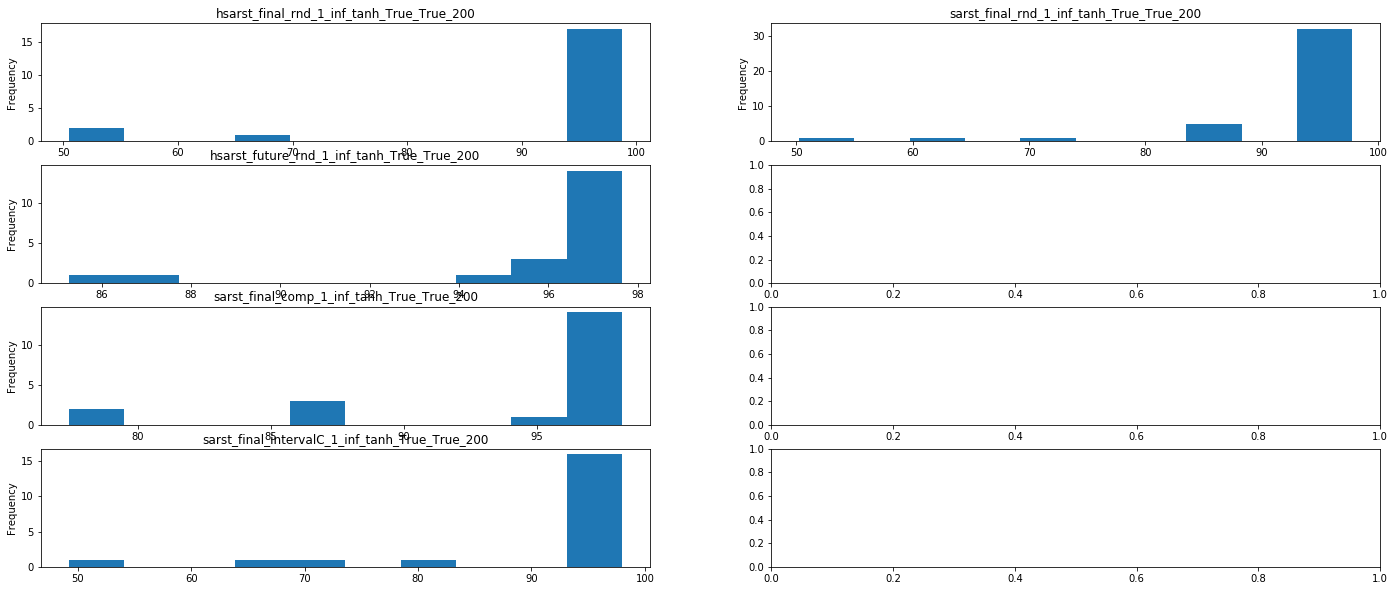

In [20]:
fig, axes = plt.subplots(4,2, figsize=(24,10))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on random goal']):
    g.plot(kind='hist', title=name, ax=axes[i%4, i//4])

In [19]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    param_names = ['memory', 'strategy', 'sampler', 'alpha', 'delta', 'activation', 'invert_grads', 'target_clip']
    res_episodes = glob.glob(LOGDIR + PARAM + '/*/' + 'log_episodes/progress.json')
    for num_run, run in enumerate(res_episodes):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes

,Duration,Episode,Episode steps,Goal,Goal reached,Start,Train reward,Train step,params,num_run
0,7.894050,1,262,-0.301667,1,-0.546436,99.378046,262,sarst_final_rnd_1_inf_linear_True_False_1000,0
1,102.731069,2,1000,0.200417,1,-0.455342,-69.166653,1262,sarst_final_rnd_1_inf_linear_True_False_1000,0
2,195.081424,3,1000,0.529068,1,-0.417209,-96.111885,2262,sarst_final_rnd_1_inf_linear_True_False_1000,0
3,288.765478,4,1000,0.078793,1,-0.521846,-64.369100,3262,sarst_final_rnd_1_inf_linear_True_False_1000,0
4,382.884678,5,1000,0.346282,1,-0.587518,-45.436014,4262,sarst_final_rnd_1_inf_linear_True_False_1000,0
5,383.813540,6,16,-0.263813,2,-0.424731,98.869743,4278,sarst_final_rnd_1_inf_linear_True_False_1000,0
6,417.070729,7,582,-0.788630,3,-0.470459,63.492290,4860,sarst_final_rnd_1_inf_linear_True_False_1000,0
7,459.153830,8,186,-0.275940,4,-0.578369,98.366745,5046,sarst_final_rnd_1_inf_linear_True_False_1000,0
8,559.911624,9,1000,-0.004656,4,-0.437942,-95.971398,6046,sarst_final_rnd_1_inf_linear_True_False_1000,0
9,657.324387,10,1000,-1.154962,4,-0.528218,-99.954942,7046,sarst_final_rnd_1_inf_linear_True_False_1000,0


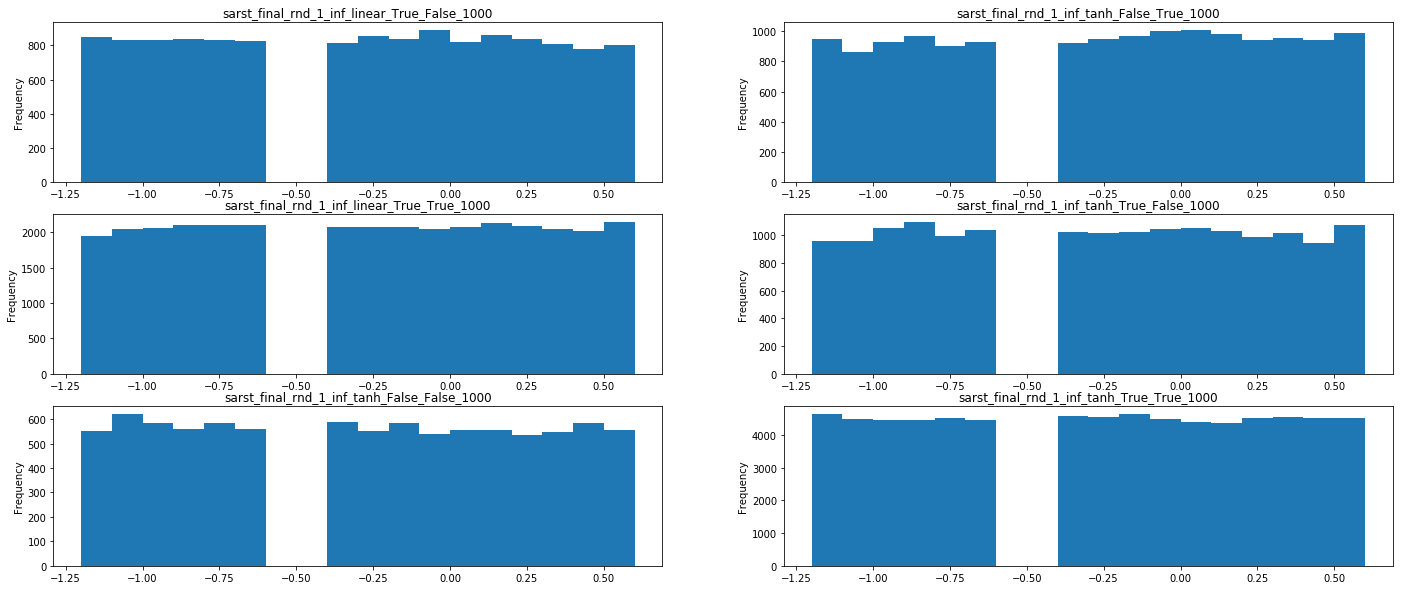

In [22]:
fig, axes = plt.subplots(3,2, figsize=(24,10))
for i,(name, g) in enumerate(expe_res_episodes.groupby('params')['Goal']):
    g.plot(kind='hist', title=name, ax=axes[i%3, i//3], bins=18)